In [1]:
!pip install wordcloud nltk transformers torch

In [2]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.corpus import stopwords
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from transformers import BertModel, BertTokenizer
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, roc_curve, auc
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Análisis exploratorio de los datos

In [4]:
data = pd.read_csv("Data_SentimentAnalysis.csv")

In [5]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
# ¿Cuántas observaciones y variables tienen el dataset?
observaciones, variables = data.shape
print("El conjunto de datos tiene", observaciones, "observaciones y", variables, "variables.")

El conjunto de datos tiene 14640 observaciones y 15 variables.


In [7]:
# ¿Qué tipo de variables son?
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [8]:
# ¿Qué variables contienen valores nulos?
print(data.isnull().sum())

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64


In [9]:
# Opciones para las columnas
'''
# Reemplazar valores nulos en columnas de razón negativa con 'No negativo'
data['negativereason'] = data['negativereason'].fillna('No negativo')
data['negativereason_gold'] = data['negativereason_gold'].fillna('No negativo')

# Reemplazar valores nulos en la columna de confianza de razón negativa con la mediana
median = data['negativereason_confidence'].median()
data['negativereason_confidence'] = data['negativereason_confidence'].fillna(median)

# Reemplazar valores nulos en la columna de sentimiento gold con 'Desconocido'
data['airline_sentiment_gold'] = data['airline_sentiment_gold'].fillna('Desconocido')

# Reemplazar valores nulos en columnas de ubicación con 'Desconocido'
data['tweet_coord'] = data['tweet_coord'].fillna('Desconocido')
data['tweet_location'] = data['tweet_location'].fillna('Desconocido')
data['user_timezone'] = data['user_timezone'].fillna('Desconocido')
'''

"\n# Reemplazar valores nulos en columnas de razón negativa con 'No negativo'\ndata['negativereason'] = data['negativereason'].fillna('No negativo')\ndata['negativereason_gold'] = data['negativereason_gold'].fillna('No negativo')\n\n# Reemplazar valores nulos en la columna de confianza de razón negativa con la mediana\nmedian = data['negativereason_confidence'].median()\ndata['negativereason_confidence'] = data['negativereason_confidence'].fillna(median)\n\n# Reemplazar valores nulos en la columna de sentimiento gold con 'Desconocido'\ndata['airline_sentiment_gold'] = data['airline_sentiment_gold'].fillna('Desconocido')\n\n# Reemplazar valores nulos en columnas de ubicación con 'Desconocido'\ndata['tweet_coord'] = data['tweet_coord'].fillna('Desconocido')\ndata['tweet_location'] = data['tweet_location'].fillna('Desconocido')\ndata['user_timezone'] = data['user_timezone'].fillna('Desconocido')\n"

In [10]:
# Datos por aerolínea y sentimiento, y luego contar los tweets
grouped = data.groupby(['airline', 'airline_sentiment']).count().iloc[:,0]

# Grupo en un dataframe y resetear el índice
grouped = grouped.to_frame().reset_index()

# Pivotear el dataframe para que los sentimientos sean las columnas y las filas sean las aerolíneas
grouped = grouped.pivot(index='airline', columns='airline_sentiment', values='tweet_id')

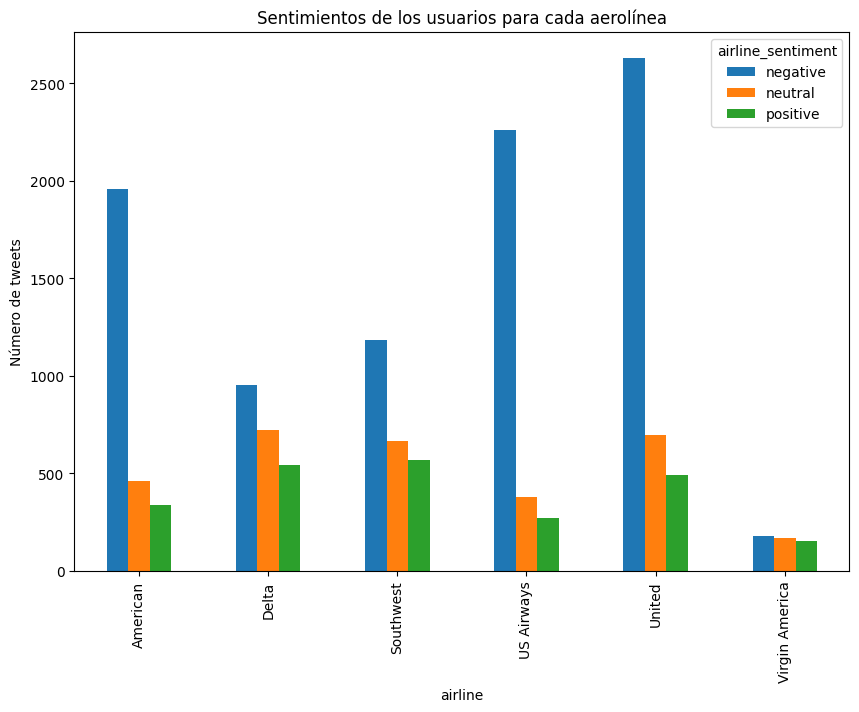

In [11]:
# Gráfico de barras
grouped.plot(kind='bar', figsize=(10, 7))
plt.title('Sentimientos de los usuarios para cada aerolínea')
plt.ylabel('Número de tweets')
plt.show()

In [12]:
nltk.download('stopwords')
# Lista de stopwords
stop = set(stopwords.words('english'))

# Función para generar una nube de palabras
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40,
        scale=3,
        random_state=42,
        stopwords=stop
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title:
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
def procesar_texto(texto):
    # Convertir a string
    texto = ' '.join(texto)

    # Eliminar los '@nombre_de_usuario', URLs y emojis
    texto = ' '.join(word for word in texto.split() if not word.startswith('@') and 'http' not in word)

    # Eliminar emojis mediante expresiones regulares
    # Esta regex abarca la mayoría de los emojis
    texto = re.sub(r'[\U00010000-\U0010ffff]', '', texto)

    return texto

In [14]:
negativos = procesar_texto(data[data['airline_sentiment']=='negative']['text'])


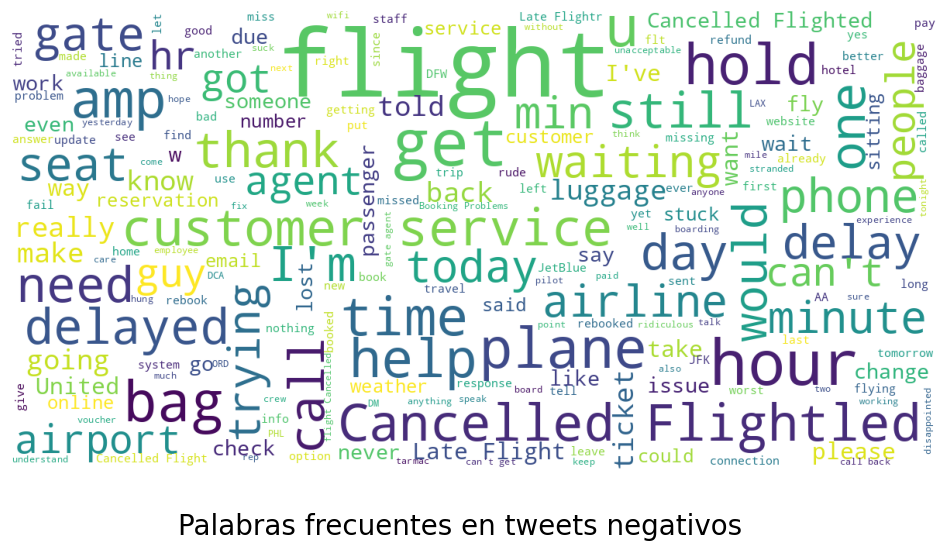

In [15]:
# Nube de palabras para los tweets negativos
show_wordcloud(negativos, title = 'Palabras frecuentes en tweets negativos')

In [16]:
positivos = procesar_texto(data[data['airline_sentiment']=='positive']['text'])

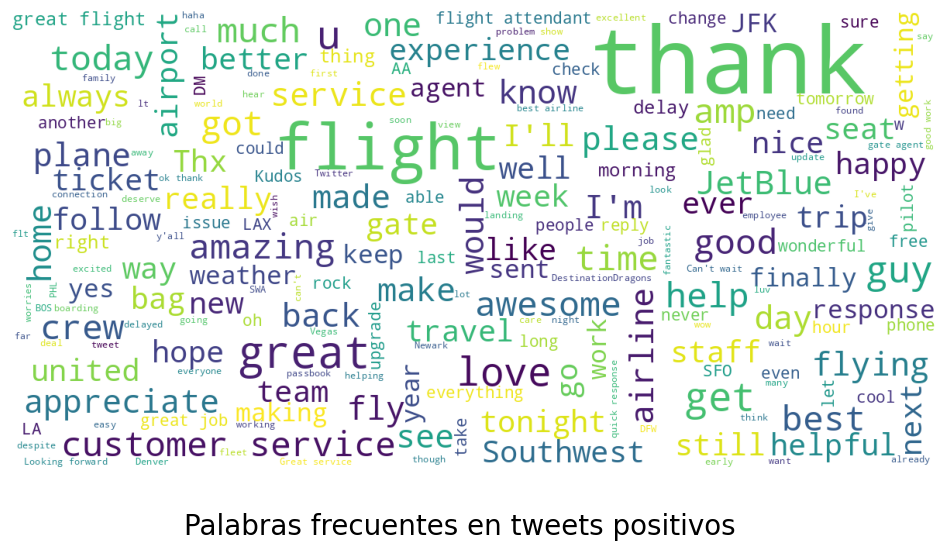

In [17]:
# Nube de palabras para los tweets positivos
show_wordcloud(positivos, title = 'Palabras frecuentes en tweets positivos')

In [18]:
# Datos por aerolínea y negativereason, y luego contar los tweets
grouped_reason = data[data['airline_sentiment'] == 'negative'].groupby(['airline', 'negativereason']).count().iloc[:,0]

grouped_reason = grouped_reason.to_frame().reset_index()

# Pivotear el dataframe para que las razones negativas sean las columnas y las filas sean las aerolíneas
grouped_reason = grouped_reason.pivot(index='airline', columns='negativereason', values='tweet_id')

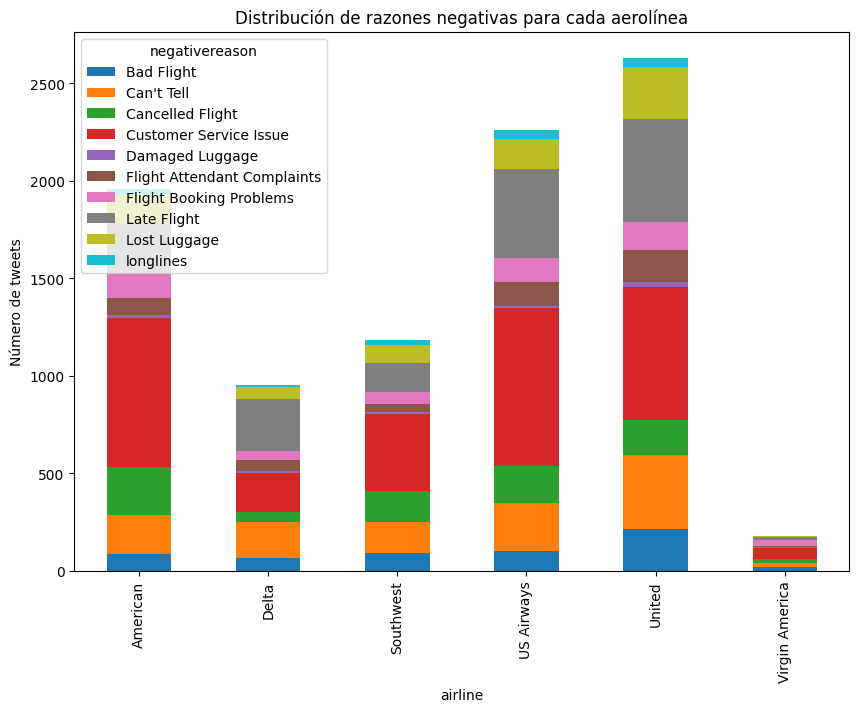

In [19]:
# Gráfico de barras
grouped_reason.plot(kind='bar', stacked=True, figsize=(10, 7))
plt.title('Distribución de razones negativas para cada aerolínea')
plt.ylabel('Número de tweets')
plt.show()

In [20]:
# Columna 'tweet_created' a datetime
data['tweet_created'] = pd.to_datetime(data['tweet_created'])

# Nueva columna con solo la fecha
data['date'] = data['tweet_created'].dt.date

# Datos por aerolínea, fecha y sentimiento, y luego contar los tweets
grouped_date = data.groupby(['airline', 'date', 'airline_sentiment']).count().iloc[:,0]

# Grupo en un dataframe y resetear el índice
grouped_date = grouped_date.to_frame().reset_index()

# tweets negativos
grouped_date_negative = grouped_date[grouped_date['airline_sentiment'] == 'negative']

# Pivotear el dataframe para que las fechas sean las columnas y las filas sean las aerolíneas
grouped_date_negative = grouped_date_negative.pivot(index='airline', columns='date', values='tweet_id')

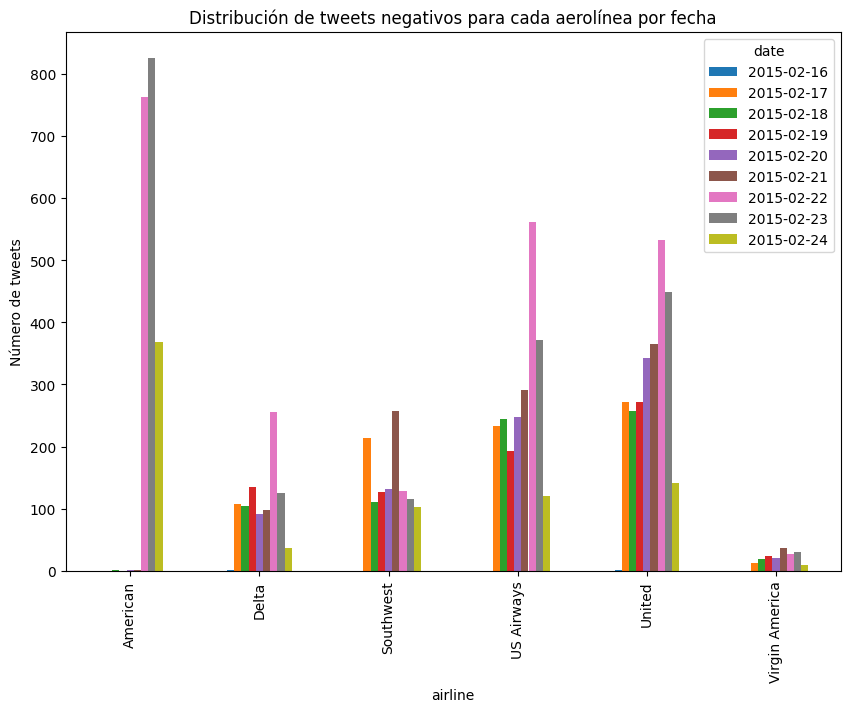

In [21]:
# Gráfico de barras
grouped_date_negative.plot(kind='bar', figsize=(10, 7))
plt.title('Distribución de tweets negativos para cada aerolínea por fecha')
plt.ylabel('Número de tweets')
plt.show()

# Preprocesamiento de texto

In [22]:
# Columnas relevantes
data_NLP = data[['tweet_id', 'airline_sentiment', 'negativereason', 'text']]

In [23]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [24]:
from nltk.tokenize import word_tokenize
# Tokenizador a la columna 'text'
data_NLP['cleaned_text'] = data_NLP['text'].apply( lambda x: word_tokenize(x))

In [25]:
data_NLP

,tweet_id,airline_sentiment,negativereason,text,cleaned_text
0,570306133677760513,neutral,NaN,@VirginAmerica What @dhepburn said.,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,570301130888122368,positive,NaN,@VirginAmerica plus you've added commercials t...,"[@, VirginAmerica, plus, you, 've, added, comm..."
2,570301083672813571,neutral,NaN,@VirginAmerica I didn't today... Must mean I n...,"[@, VirginAmerica, I, did, n't, today, ..., Mu..."
3,570301031407624196,negative,Bad Flight,@VirginAmerica it's really aggressive to blast...,"[@, VirginAmerica, it, 's, really, aggressive,..."
4,570300817074462722,negative,Can't Tell,@VirginAmerica and it's a really big bad thing...,"[@, VirginAmerica, and, it, 's, a, really, big..."
...,...,...,...,...,...
14635,569587686496825344,positive,NaN,@AmericanAir thank you we got on a different f...,"[@, AmericanAir, thank, you, we, got, on, a, d..."
14636,569587371693355008,negative,Customer Service Issue,@AmericanAir leaving over 20 minutes Late Flig...,"[@, AmericanAir, leaving, over, 20, minutes, L..."
14637,569587242672398336,neutral,NaN,@AmericanAir Please bring American Airlines to...,"[@, AmericanAir, Please, bring, American, Airl..."
14638,569587188687634433,negative,Customer Service Issue,"@AmericanAir you have my money, you change my ...","[@, AmericanAir, you, have, my, money, ,, you,..."


In [26]:
stops = set(stopwords.words('english'))

In [27]:
# Eliminar las stopwords de la columna 'cleaned_text'
data_NLP['cleaned_text'] = data_NLP['cleaned_text'].apply(lambda x: [item for item in x if item not in stops])

In [28]:
data_NLP

,tweet_id,airline_sentiment,negativereason,text,cleaned_text
0,570306133677760513,neutral,NaN,@VirginAmerica What @dhepburn said.,"[@, VirginAmerica, What, @, dhepburn, said, .]"
1,570301130888122368,positive,NaN,@VirginAmerica plus you've added commercials t...,"[@, VirginAmerica, plus, 've, added, commercia..."
2,570301083672813571,neutral,NaN,@VirginAmerica I didn't today... Must mean I n...,"[@, VirginAmerica, I, n't, today, ..., Must, m..."
3,570301031407624196,negative,Bad Flight,@VirginAmerica it's really aggressive to blast...,"[@, VirginAmerica, 's, really, aggressive, bla..."
4,570300817074462722,negative,Can't Tell,@VirginAmerica and it's a really big bad thing...,"[@, VirginAmerica, 's, really, big, bad, thing]"
...,...,...,...,...,...
14635,569587686496825344,positive,NaN,@AmericanAir thank you we got on a different f...,"[@, AmericanAir, thank, got, different, flight..."
14636,569587371693355008,negative,Customer Service Issue,@AmericanAir leaving over 20 minutes Late Flig...,"[@, AmericanAir, leaving, 20, minutes, Late, F..."
14637,569587242672398336,neutral,NaN,@AmericanAir Please bring American Airlines to...,"[@, AmericanAir, Please, bring, American, Airl..."
14638,569587188687634433,negative,Customer Service Issue,"@AmericanAir you have my money, you change my ...","[@, AmericanAir, money, ,, change, flight, ,, ..."


In [29]:
# Convertir todas las palabras en minúsculas y eliminar los signos de puntuación
data_NLP['cleaned_text'] = data_NLP['cleaned_text'].apply(lambda x: [item.lower() for item in x])
data_NLP['cleaned_text'] = data_NLP['cleaned_text'].apply(lambda x: [re.sub(r'\W+', '', item) for item in x])
data_NLP['cleaned_text'] = data_NLP['cleaned_text'].apply(lambda x: [item for item in x if len(item)>3])

In [30]:
data_NLP

,tweet_id,airline_sentiment,negativereason,text,cleaned_text
0,570306133677760513,neutral,NaN,@VirginAmerica What @dhepburn said.,"[virginamerica, what, dhepburn, said]"
1,570301130888122368,positive,NaN,@VirginAmerica plus you've added commercials t...,"[virginamerica, plus, added, commercials, expe..."
2,570301083672813571,neutral,NaN,@VirginAmerica I didn't today... Must mean I n...,"[virginamerica, today, must, mean, need, take,..."
3,570301031407624196,negative,Bad Flight,@VirginAmerica it's really aggressive to blast...,"[virginamerica, really, aggressive, blast, obn..."
4,570300817074462722,negative,Can't Tell,@VirginAmerica and it's a really big bad thing...,"[virginamerica, really, thing]"
...,...,...,...,...,...
14635,569587686496825344,positive,NaN,@AmericanAir thank you we got on a different f...,"[americanair, thank, different, flight, chicago]"
14636,569587371693355008,negative,Customer Service Issue,@AmericanAir leaving over 20 minutes Late Flig...,"[americanair, leaving, minutes, late, flight, ..."
14637,569587242672398336,neutral,NaN,@AmericanAir Please bring American Airlines to...,"[americanair, please, bring, american, airline..."
14638,569587188687634433,negative,Customer Service Issue,"@AmericanAir you have my money, you change my ...","[americanair, money, change, flight, answer, p..."


In [31]:
stemmer = PorterStemmer()

# Aplicar el stemming a la columna 'cleaned_text'
data_NLP['cleaned_text'] = data_NLP['cleaned_text'].apply(lambda x: [stemmer.stem(i) for i in x]) # stemming

In [32]:
data_NLP

,tweet_id,airline_sentiment,negativereason,text,cleaned_text
0,570306133677760513,neutral,NaN,@VirginAmerica What @dhepburn said.,"[virginamerica, what, dhepburn, said]"
1,570301130888122368,positive,NaN,@VirginAmerica plus you've added commercials t...,"[virginamerica, plu, ad, commerci, experi, tacki]"
2,570301083672813571,neutral,NaN,@VirginAmerica I didn't today... Must mean I n...,"[virginamerica, today, must, mean, need, take,..."
3,570301031407624196,negative,Bad Flight,@VirginAmerica it's really aggressive to blast...,"[virginamerica, realli, aggress, blast, obnoxi..."
4,570300817074462722,negative,Can't Tell,@VirginAmerica and it's a really big bad thing...,"[virginamerica, realli, thing]"
...,...,...,...,...,...
14635,569587686496825344,positive,NaN,@AmericanAir thank you we got on a different f...,"[americanair, thank, differ, flight, chicago]"
14636,569587371693355008,negative,Customer Service Issue,@AmericanAir leaving over 20 minutes Late Flig...,"[americanair, leav, minut, late, flight, warn,..."
14637,569587242672398336,neutral,NaN,@AmericanAir Please bring American Airlines to...,"[americanair, pleas, bring, american, airlin, ..."
14638,569587188687634433,negative,Customer Service Issue,"@AmericanAir you have my money, you change my ...","[americanair, money, chang, flight, answer, ph..."


In [33]:
# Tokenizador preentrenado de BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Modelo preentrenado de BERT
model = BertModel.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
def bert_embeddings(text):
    # Tokenizamos el texto
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)

    # Embeddings de BERT
    with torch.no_grad():
        outputs = model(**inputs)

    embeddings = outputs.last_hidden_state

    # Media de los embeddings a lo largo del eje de la longitud de la secuencia
    embeddings = embeddings.mean(dim=1)

    return embeddings.numpy()

In [35]:
data_NLP["embeddings_text"] = data_NLP["cleaned_text"].apply(bert_embeddings)


In [36]:
data_NLP

,tweet_id,airline_sentiment,negativereason,text,cleaned_text,embeddings_text
0,570306133677760513,neutral,NaN,@VirginAmerica What @dhepburn said.,"[virginamerica, what, dhepburn, said]","[[0.3321362, -0.14452557, -0.015417139, 0.2978..."
1,570301130888122368,positive,NaN,@VirginAmerica plus you've added commercials t...,"[virginamerica, plu, ad, commerci, experi, tacki]","[[0.30380374, -0.13071464, -0.11325791, 0.2579..."
2,570301083672813571,neutral,NaN,@VirginAmerica I didn't today... Must mean I n...,"[virginamerica, today, must, mean, need, take,...","[[0.30380374, -0.13071464, -0.11325791, 0.2579..."
3,570301031407624196,negative,Bad Flight,@VirginAmerica it's really aggressive to blast...,"[virginamerica, realli, aggress, blast, obnoxi...","[[0.33213553, -0.14452569, -0.015417497, 0.297..."
4,570300817074462722,negative,Can't Tell,@VirginAmerica and it's a really big bad thing...,"[virginamerica, realli, thing]","[[0.30380374, -0.13071464, -0.11325791, 0.2579..."
...,...,...,...,...,...,...
14635,569587686496825344,positive,NaN,@AmericanAir thank you we got on a different f...,"[americanair, thank, differ, flight, chicago]","[[0.5867883, 0.24999432, 0.20065112, 0.1315208..."
14636,569587371693355008,negative,Customer Service Issue,@AmericanAir leaving over 20 minutes Late Flig...,"[americanair, leav, minut, late, flight, warn,...","[[0.5867888, 0.24999447, 0.20065105, 0.1315205..."
14637,569587242672398336,neutral,NaN,@AmericanAir Please bring American Airlines to...,"[americanair, pleas, bring, american, airlin, ...","[[0.5867883, 0.24999432, 0.20065112, 0.1315208..."
14638,569587188687634433,negative,Customer Service Issue,"@AmericanAir you have my money, you change my ...","[americanair, money, chang, flight, answer, ph...","[[0.5867883, 0.24999432, 0.20065112, 0.1315208..."


In [37]:
data_filter = data_NLP[data_NLP['airline_sentiment']!='neutral']

In [38]:
data_filter

,tweet_id,airline_sentiment,negativereason,text,cleaned_text,embeddings_text
1,570301130888122368,positive,NaN,@VirginAmerica plus you've added commercials t...,"[virginamerica, plu, ad, commerci, experi, tacki]","[[0.30380374, -0.13071464, -0.11325791, 0.2579..."
3,570301031407624196,negative,Bad Flight,@VirginAmerica it's really aggressive to blast...,"[virginamerica, realli, aggress, blast, obnoxi...","[[0.33213553, -0.14452569, -0.015417497, 0.297..."
4,570300817074462722,negative,Can't Tell,@VirginAmerica and it's a really big bad thing...,"[virginamerica, realli, thing]","[[0.30380374, -0.13071464, -0.11325791, 0.2579..."
5,570300767074181121,negative,Can't Tell,@VirginAmerica seriously would pay $30 a fligh...,"[virginamerica, serious, would, flight, seat, ...","[[0.30380374, -0.13071464, -0.11325791, 0.2579..."
6,570300616901320704,positive,NaN,"@VirginAmerica yes, nearly every time I fly VX...","[virginamerica, nearli, everi, time, worm, away]","[[0.30380374, -0.13071464, -0.11325791, 0.2579..."
...,...,...,...,...,...,...
14633,569587705937600512,negative,Cancelled Flight,@AmericanAir my flight was Cancelled Flightled...,"[americanair, flight, cancel, flightl, leav, t...","[[0.5867888, 0.24999447, 0.20065105, 0.1315205..."
14634,569587691626622976,negative,Late Flight,@AmericanAir right on cue with the delays👌,"[americanair, right, delay]","[[0.5867883, 0.24999432, 0.20065112, 0.1315208..."
14635,569587686496825344,positive,NaN,@AmericanAir thank you we got on a different f...,"[americanair, thank, differ, flight, chicago]","[[0.5867883, 0.24999432, 0.20065112, 0.1315208..."
14636,569587371693355008,negative,Customer Service Issue,@AmericanAir leaving over 20 minutes Late Flig...,"[americanair, leav, minut, late, flight, warn,...","[[0.5867888, 0.24999447, 0.20065105, 0.1315205..."


In [39]:
from sklearn.model_selection import train_test_split

# Variables objetivo y explicativas
X_caso1 = data_filter['cleaned_text'].apply(lambda x: ' '.join(x)) # Convertimos las listas a strings
X_caso2 = data_filter['embeddings_text']
y = data_filter['airline_sentiment']

In [40]:
# Datos para el caso de uso 1
X_train_caso1, X_temp, y_train_caso1, y_temp = train_test_split(X_caso1, y, test_size=0.3, random_state=126)
X_val_caso1, X_test_caso1, y_val_caso1, y_test_caso1 = train_test_split(X_temp, y_temp, test_size=0.67, random_state=126)

In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()

In [42]:
# Entrenamos el transformador con los datos de entrenamiento y transformamos los datos
X_train_caso1_tfidf = vectorizer.fit_transform(X_train_caso1)

In [43]:
# Transformamos los datos de validación y test (no se hace fit para evitar data leakage)
X_val_caso1_tfidf = vectorizer.transform(X_val_caso1)
X_test_caso1_tfidf = vectorizer.transform(X_test_caso1)

# Topic Modelling


In [44]:
# Definir modelos
log_reg = LogisticRegression(random_state=126)
rand_forest = RandomForestClassifier(random_state=126)
linear_svc = LinearSVC(random_state=126)
grad_boost = GradientBoostingClassifier(random_state=126)

In [45]:
# Entrenar modelos
log_reg.fit(X_train_caso1_tfidf, y_train_caso1)
rand_forest.fit(X_train_caso1_tfidf, y_train_caso1)
linear_svc.fit(X_train_caso1_tfidf, y_train_caso1)
grad_boost.fit(X_train_caso1_tfidf, y_train_caso1)

GradientBoostingClassifier(random_state=126)

In [46]:
# Predicciones en el conjunto de prueba
log_reg_preds = log_reg.predict(X_test_caso1_tfidf)
rand_forest_preds = rand_forest.predict(X_test_caso1_tfidf)
linear_svc_preds = linear_svc.predict(X_test_caso1_tfidf)
grad_boost_preds = grad_boost.predict(X_test_caso1_tfidf)


In [47]:
# Matrices de confusión
log_reg_cm = confusion_matrix(y_test_caso1, log_reg_preds)
rand_forest_cm = confusion_matrix(y_test_caso1, rand_forest_preds)
linear_svc_cm = confusion_matrix(y_test_caso1, linear_svc_preds)
grad_boost_cm = confusion_matrix(y_test_caso1, grad_boost_preds)

In [48]:
# Mostrar las matrices de confusión
print("Logistic Regression Confusion Matrix: \n", log_reg_cm)

Logistic Regression Confusion Matrix: 
 [[1815   41]
 [ 181  284]]


In [49]:
print("Random Forest Confusion Matrix: \n", rand_forest_cm)

Random Forest Confusion Matrix: 
 [[1798   58]
 [ 176  289]]


In [50]:
print("Linear SVC Confusion Matrix: \n", linear_svc_cm)

Linear SVC Confusion Matrix: 
 [[1777   79]
 [ 137  328]]


In [51]:
print("Gradient Boosting Confusion Matrix: \n", grad_boost_cm)

Gradient Boosting Confusion Matrix: 
 [[1807   49]
 [ 230  235]]


In [52]:
# Accuracy
log_reg_acc = accuracy_score(y_test_caso1, log_reg_preds)
rand_forest_acc = accuracy_score(y_test_caso1, rand_forest_preds)
linear_svc_acc = accuracy_score(y_test_caso1, linear_svc_preds)
grad_boost_acc = accuracy_score(y_test_caso1, grad_boost_preds)

In [53]:
# Mostrar accuracy
print("Logistic Regression Accuracy: ", log_reg_acc)
print("Random Forest Accuracy: ", rand_forest_acc)
print("Linear SVC Accuracy: ", linear_svc_acc)
print("Gradient Boosting Accuracy: ", grad_boost_acc)

Logistic Regression Accuracy:  0.9043515725980181
Random Forest Accuracy:  0.8991813873330461
Linear SVC Accuracy:  0.9069366652305041
Gradient Boosting Accuracy:  0.8797931925894011


In [54]:
# Recall
log_reg_recall = recall_score(y_test_caso1, log_reg_preds, pos_label='negative')
rand_forest_recall = recall_score(y_test_caso1, rand_forest_preds, pos_label='negative')
linear_svc_recall = recall_score(y_test_caso1, linear_svc_preds, pos_label='negative')
grad_boost_recall = recall_score(y_test_caso1, grad_boost_preds, pos_label='negative')

In [55]:
# Mostrar recall
print("Logistic Regression Recall: ", log_reg_recall)
print("Random Forest Recall: ", rand_forest_recall)
print("Linear SVC Recall: ", linear_svc_recall)
print("Gradient Boosting Recall: ", grad_boost_recall)

Logistic Regression Recall:  0.9779094827586207
Random Forest Recall:  0.96875
Linear SVC Recall:  0.9574353448275862
Gradient Boosting Recall:  0.9735991379310345


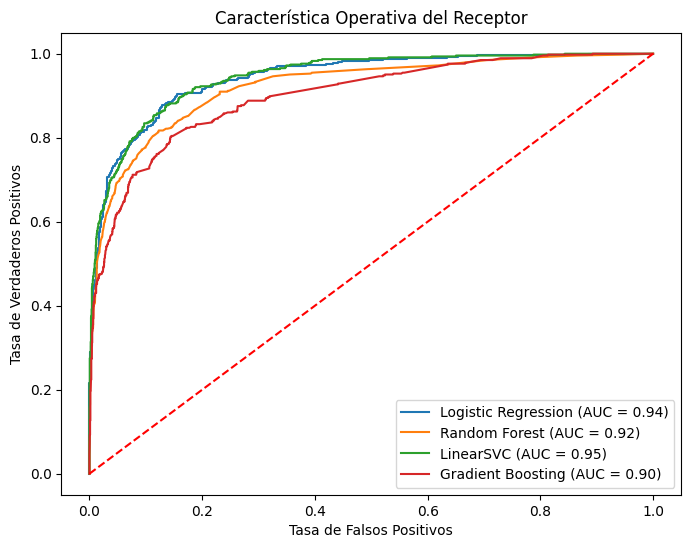

In [56]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

# Definimos una lista con los modelos y sus nombres
models = [(log_reg, 'Logistic Regression'),
          (rand_forest, 'Random Forest'),
          (linear_svc, 'LinearSVC'),
          (grad_boost, 'Gradient Boosting')]

plt.figure(figsize=(8,6))

# Iteramos por cada modelo
for model, name in models:
    if name == 'LinearSVC':
        # Predicciones de los scores de decisión para LinearSVC
        preds = model.decision_function(X_test_caso1_tfidf)
    else:
        # Predicciones de la probabilidad de la clase positiva
        preds = model.predict_proba(X_test_caso1_tfidf)[:, 1]

    # Calculamos la tasa de verdaderos y falsos positivos
    fpr, tpr, _ = roc_curve(y_test_caso1.map({'negative': 0, 'positive': 1}), preds)

    # Calculamos el AUC
    roc_auc = auc(fpr, tpr)

    # Graficamos la curva ROC para el modelo actual
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.title('Característica Operativa del Receptor')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')

plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')

plt.show()


In [57]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Hiperparámetros que queremos optimizar y sus rangos de búsqueda
param_dist = {
    "C": uniform(loc=0, scale=4),
    "fit_intercept": [True, False],
    "max_iter": [500, 1000, 1500],
    "tol": [1e-3, 1e-4, 1e-5]
}

In [58]:
# Modelo LinearSVC
model = LinearSVC(random_state=126)

In [59]:
# Realizamos la búsqueda de hiperparámetros
n_iter_search = 20
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=n_iter_search, cv=5, random_state=126)

In [60]:
# Entrenamos modelo
random_search.fit(X_train_caso1_tfidf, y_train_caso1)

RandomizedSearchCV(cv=5, estimator=LinearSVC(random_state=126), n_iter=20,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f9a11208df0>,
                                        'fit_intercept': [True, False],
                                        'max_iter': [500, 1000, 1500],
                                        'tol': [0.001, 0.0001, 1e-05]},
                   random_state=126)

In [61]:
# Mejores configuraciones de hiperparámetros
print(random_search.best_params_)

{'C': 0.3391254398274106, 'fit_intercept': False, 'max_iter': 500, 'tol': 0.0001}


In [62]:
# Evaluamos modelo
predictions = random_search.predict(X_test_caso1_tfidf)
print("Accuracy: ", accuracy_score(y_test_caso1, predictions))
print("Recall: ", recall_score(y_test_caso1, predictions, pos_label='negative'))

Accuracy:  0.9112451529513141
Recall:  0.9665948275862069


In [63]:
# Matriz de confusión
print("Confusion Matrix: \n", confusion_matrix(y_test_caso1, predictions))

Confusion Matrix: 
 [[1794   62]
 [ 144  321]]


In [64]:
data_filter.head()

,tweet_id,airline_sentiment,negativereason,text,cleaned_text,embeddings_text
1,570301130888122368,positive,NaN,@VirginAmerica plus you've added commercials t...,"[virginamerica, plu, ad, commerci, experi, tacki]","[[0.30380374, -0.13071464, -0.11325791, 0.2579..."
3,570301031407624196,negative,Bad Flight,@VirginAmerica it's really aggressive to blast...,"[virginamerica, realli, aggress, blast, obnoxi...","[[0.33213553, -0.14452569, -0.015417497, 0.297..."
4,570300817074462722,negative,Can't Tell,@VirginAmerica and it's a really big bad thing...,"[virginamerica, realli, thing]","[[0.30380374, -0.13071464, -0.11325791, 0.2579..."
5,570300767074181121,negative,Can't Tell,@VirginAmerica seriously would pay $30 a fligh...,"[virginamerica, serious, would, flight, seat, ...","[[0.30380374, -0.13071464, -0.11325791, 0.2579..."
6,570300616901320704,positive,NaN,"@VirginAmerica yes, nearly every time I fly VX...","[virginamerica, nearli, everi, time, worm, away]","[[0.30380374, -0.13071464, -0.11325791, 0.2579..."


In [65]:
data_neg = data_filter[data_filter['airline_sentiment'] == 'negative']

In [66]:
data_neg.head()

,tweet_id,airline_sentiment,negativereason,text,cleaned_text,embeddings_text
3,570301031407624196,negative,Bad Flight,@VirginAmerica it's really aggressive to blast...,"[virginamerica, realli, aggress, blast, obnoxi...","[[0.33213553, -0.14452569, -0.015417497, 0.297..."
4,570300817074462722,negative,Can't Tell,@VirginAmerica and it's a really big bad thing...,"[virginamerica, realli, thing]","[[0.30380374, -0.13071464, -0.11325791, 0.2579..."
5,570300767074181121,negative,Can't Tell,@VirginAmerica seriously would pay $30 a fligh...,"[virginamerica, serious, would, flight, seat, ...","[[0.30380374, -0.13071464, -0.11325791, 0.2579..."
15,570282469121007616,negative,Late Flight,@VirginAmerica SFO-PDX schedule is still MIA.,"[virginamerica, sfopdx, schedul, still]","[[0.35814613, -0.16599645, 0.04096922, 0.31290..."
17,570276917301137409,negative,Bad Flight,@VirginAmerica I flew from NYC to SFO last we...,"[virginamerica, flew, last, week, could, fulli...","[[0.30380315, -0.13071468, -0.11325818, 0.2579..."


In [67]:
# Datos negativos
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(data_neg["text"], data_neg["negativereason"], test_size=0.3, random_state=126)

In [68]:
# Muestra la distribución de las clases
class_distribution = data_neg['negativereason'].value_counts()
print(class_distribution)

Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64


In [69]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report

# Inicializamos el codificador de etiquetas
le = LabelEncoder()

# Ajustamos y transformamos las etiquetas de entrenamiento
y_train_encoded = le.fit_transform(y_train_neg)

# Etiquetas de validación y test (no hagas fit para evitar data leakage)
y_test_encoded = le.transform(y_test_neg)

# Inicializamos el vectorizador TF-IDF
vectorizer = TfidfVectorizer()

# Ajustamos y transformamos los datos de entrenamiento
X_train_tfidf = vectorizer.fit_transform(X_train_neg)

# Transformamos los datos de prueba (no hagas fit para evitar data leakage)
X_test_tfidf = vectorizer.transform(X_test_neg)

# Modelo XGBoost inicial
xgb_model = XGBClassifier(random_state=126)

# Hiperparámetros para la búsqueda
params = {
    'min_child_weight': [1, 5, 10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5]
}

# Definimos RandomizedSearchCV
random_search = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=5,
                                   scoring='roc_auc', n_jobs=1, cv=5, verbose=3, random_state=126)

# Búsqueda para encontrar los mejores hiperparámetros
random_search.fit(X_train_tfidf, y_train_encoded)

# Mejores hiperparámetros encontrados
print("Mejores hiperparámetros: ", random_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=nan total time=  14.9s
[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=nan total time=  14.7s
[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=nan total time=  14.8s
[CV 4/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=nan total time=  14.6s
[CV 5/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=5, subsample=0.6;, score=nan total time=  14.4s
[CV 1/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=nan total time=  12.8s
[CV 2/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_weight=10, subsample=0.6;, score=nan total time=  16.0s
[CV 3/5] END colsample_bytree=1.0, gamma=1.5, max_depth=3, min_child_w

In [70]:
from sklearn.metrics import classification_report, confusion_matrix
# Realizamos la predicción en el conjunto de prueba
y_pred = random_search.predict(X_test_tfidf)

# Transformamos las etiquetas verdaderas para el conjunto de prueba
y_true = le.inverse_transform(y_test_encoded)

# Transformamos las predicciones
y_pred = le.inverse_transform(y_pred)

# Reporte de clasificación
print(classification_report(y_true, y_pred))

                             precision    recall  f1-score   support

                 Bad Flight       0.50      0.31      0.38       162
                 Can't Tell       0.42      0.48      0.45       338
           Cancelled Flight       0.72      0.69      0.71       236
     Customer Service Issue       0.59      0.73      0.65       889
            Damaged Luggage       0.00      0.00      0.00        22
Flight Attendant Complaints       0.55      0.36      0.43       143
    Flight Booking Problems       0.53      0.32      0.40       163
                Late Flight       0.72      0.69      0.70       526
               Lost Luggage       0.66      0.70      0.68       214
                  longlines       0.47      0.13      0.21        61

                   accuracy                           0.60      2754
                  macro avg       0.51      0.44      0.46      2754
               weighted avg       0.59      0.60      0.59      2754



In [71]:
# Embeddings de texto y convertirlos en listas
embeddings = data_filter['embeddings_text'].tolist()

# Media de los embeddings para cada tweet
X_caso2 = [np.mean(tweet_embeddings, axis=0) if len(tweet_embeddings) > 0 else np.zeros(768) for tweet_embeddings in embeddings]
y = data_filter['airline_sentiment']

In [72]:
# Datos para el caso de uso 2
X_train_caso2, X_temp, y_train_caso2, y_temp = train_test_split(X_caso2, y, test_size=0.3, random_state=126)
X_val_caso2, X_test_caso2, y_val_caso2, y_test_caso2 = train_test_split(X_temp, y_temp, test_size=0.67, random_state=126)

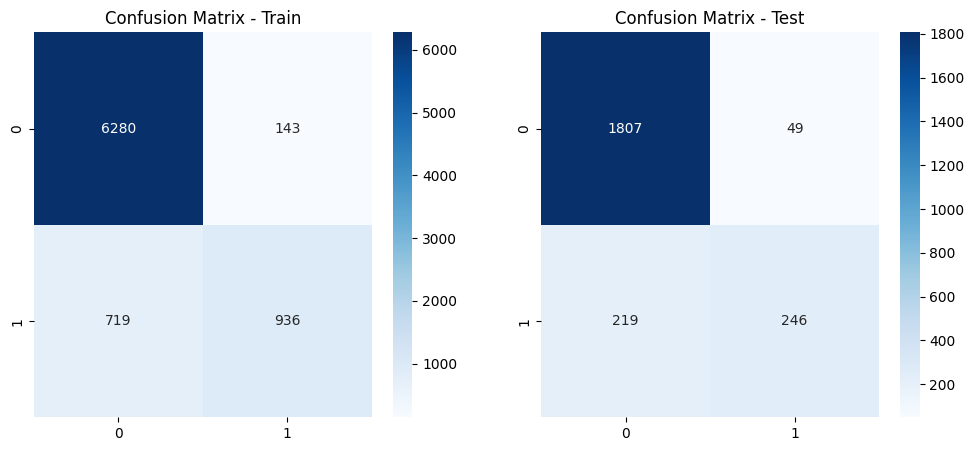

In [73]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt

# Codificación de las etiquetas de texto a números
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train_caso2)
y_test_encoded = encoder.transform(y_test_caso2)

# Creamos la instancia del modelo MLP con una capa oculta de 128 neuronas
mlp = MLPClassifier(hidden_layer_sizes=(128,), random_state=128, max_iter=10)

# Entrenamos el modelo
mlp.fit(X_train_caso2, y_train_encoded)

# Predicciones
train_preds = mlp.predict(X_train_caso2)
test_preds = mlp.predict(X_test_caso2)

# Matrices de confusión
train_conf_matrix = confusion_matrix(y_train_encoded, train_preds)
test_conf_matrix = confusion_matrix(y_test_encoded, test_preds)

# Visualización
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(train_conf_matrix, annot=True, fmt='d', ax=ax[0], cmap='Blues')
ax[0].set_title('Confusion Matrix - Train')
sns.heatmap(test_conf_matrix, annot=True, fmt='d', ax=ax[1], cmap='Blues')
ax[1].set_title('Confusion Matrix - Test')
plt.show()

In [74]:
from sklearn.metrics import classification_report

y_pred_caso2 = mlp.predict(X_test_caso2)
y_pred_caso2 = encoder.inverse_transform(y_pred_caso2)
print(classification_report(y_test_caso2, y_pred_caso2))

              precision    recall  f1-score   support

    negative       0.89      0.97      0.93      1856
    positive       0.83      0.53      0.65       465

    accuracy                           0.88      2321
   macro avg       0.86      0.75      0.79      2321
weighted avg       0.88      0.88      0.87      2321



In [75]:
# Preprocesamiento de datos
data_filter = data_NLP[data_NLP['airline_sentiment']!='neutral']
X_caso1 = data_filter['cleaned_text'].apply(lambda x: ' '.join(x)) # Convertimos las listas a strings
y = data_filter['airline_sentiment']

# División de datos
X_train_caso1, X_temp, y_train_caso1, y_temp = train_test_split(X_caso1, y, test_size=0.3, random_state=126)
X_val_caso1, X_test_caso1, y_val_caso1, y_test_caso1 = train_test_split(X_temp, y_temp, test_size=0.67, random_state=126)

# TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_caso1_tfidf = tfidf_vectorizer.fit_transform(X_train_caso1)

# Label Encoding
le = LabelEncoder()
le.fit(['positive', 'negative', 'neutral'])
y_train_encoded = le.transform(y_train_caso1)

# Entrenar modelo de sentimientos
sentiment_model = LinearSVC()
sentiment_model.fit(X_train_caso1_tfidf, y_train_encoded)

# Preparar datos para el modelo de razón
negative_tweets = data_filter[data_filter['airline_sentiment'] == 'negative']
X_neg = negative_tweets['cleaned_text'].apply(lambda x: ' '.join(x))
y_neg = negative_tweets['negativereason']
X_neg_tfidf = tfidf_vectorizer.transform(X_neg)

# Entrenar modelo de razón
reason_model = LinearSVC()
reason_model.fit(X_neg_tfidf, y_neg)

LinearSVC()

In [76]:
def analyze_tweet(tweet, sentiment_model, reason_model, tfidf_vectorizer, le):
    # Transformar el tweet usando el vectorizador TF-IDF
    tweet_transformed = tfidf_vectorizer.transform([tweet])

    # Predecir el sentimiento usando el modelo proporcionado
    sentiment = sentiment_model.predict(tweet_transformed)

    # Decodificar la etiqueta de sentimiento
    decoded_sentiment = le.inverse_transform(sentiment)[0]

    # Si el sentimiento es negativo, identificar la razón
    if decoded_sentiment == 'negative':
        reason = reason_model.predict(tweet_transformed)[0]
    else:
        reason = None

    return decoded_sentiment, reason

**Ejemplos de uso**

In [77]:
tweet = "amazing to me that we can't get any cold air from the vents."
sentiment, reason = analyze_tweet(tweet, sentiment_model, reason_model, tfidf_vectorizer, le)
print(f"Tweet: {tweet}")
print(f"Sentiment: {sentiment}")
if reason:
    print(f"Reason: {reason}")

Tweet: amazing to me that we can't get any cold air from the vents.
Sentiment: negative
Reason: Bad Flight


In [78]:
tweet = "The airplane is good"
sentiment, reason = analyze_tweet(tweet, sentiment_model, reason_model, tfidf_vectorizer, le)
print(f"Tweet: {tweet}")
print(f"Sentiment: {sentiment}")
if reason:
    print(f"Reason: {reason}")

Tweet: The airplane is good
Sentiment: positive


In [79]:
tweet = "why are your first fares in May over three times more than other carriers when all seats are available to select???"
sentiment, reason = analyze_tweet(tweet, sentiment_model, reason_model, tfidf_vectorizer, le)
print(f"Tweet: {tweet}")
print(f"Sentiment: {sentiment}")
if reason:
    print(f"Reason: {reason}")

Tweet: why are your first fares in May over three times more than other carriers when all seats are available to select???
Sentiment: negative
Reason: Late Flight
